In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity

# Switch to parent path to import local module
os.chdir('../..')
print('Switched directory to:', os.getcwd())

import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory

# plt.rc('font', family='Helvetica')

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/miniforge3/envs/diffsyn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
true = pd.DataFrame()
true['Si/Al'] = [10., 14.3, 10., 10.]
true['Ge/Si'] = [0., 0., 0., 0.]
true['B/Si'] = [0., 0., 0., 0.]
true['Na/Si'] = [0.2, 0.2, 0.3, 0.2]
true['K/Si'] = [0., 0., 0., 0.]
true['H2O/Si'] = [15., 15., 15., 15.]
true['F/Si'] = [0., 0., 0., 0.]
true['sda1/Si'] = [0.15, 0.15, 0.35, 0.1]
true['cryst_temp'] = [175., 175., 175., 175.]
true['cryst_time'] = [168., 168., 168., 168.]
true

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time
0,10.0,0.0,0.0,0.2,0.0,15.0,0.0,0.15,175.0,168.0
1,14.3,0.0,0.0,0.2,0.0,15.0,0.0,0.15,175.0,168.0
2,10.0,0.0,0.0,0.3,0.0,15.0,0.0,0.35,175.0,168.0
3,10.0,0.0,0.0,0.2,0.0,15.0,0.0,0.10,175.0,168.0


In [3]:
pred = pd.read_csv('predictions/UFI_C1COCCN2CCOCCOCCN(CCO1)CCOCCOCC2/syn_pred.csv')
pred = pred[pred['Si/Al'] > 0]

# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    pred[f'{het}/Si'] = 1. / pred[f'Si/{het}']
    pred[f'{het}/Si'] = pred[f'{het}/Si'].map(lambda x: 0. if x <= thres else x)
    pred[f'{het}'] = pred[f'{het}/Si']
    pred['Si'] = [1.]*len(pred)

tot_hets = pred[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    pred[f'{c}'] = pred[f'{c}/T'] * tot_hets
    pred[f'{c}/Si'] = pred[f'{c}'] / pred['Si']

# Filter out extreme values
pred = pred[~(pred > 1e5).any(axis=1)]

pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
2,5.000000,1.717997,99.0,250.0,0.400000,0.000000,0.000000,0.0,13.810024,0.058335,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,16.572029,16.572029,0.070002,0.070002
3,6.493506,1.717997,99.0,250.0,0.232078,0.000000,0.000000,0.0,14.705882,0.146234,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,16.970588,16.970588,0.168754,0.168754
7,6.915221,1.717997,99.0,250.0,0.237799,0.000000,0.152171,0.0,13.690950,0.062584,...,0.000000,0.000000,0.174176,0.174176,0.0,0.0,15.670778,15.670778,0.071634,0.071634
8,6.015513,1.717997,99.0,250.0,0.000000,0.380100,0.598626,0.0,18.838392,0.050000,...,0.443286,0.443286,0.698140,0.698140,0.0,0.0,21.970027,21.970027,0.058312,0.058312
10,6.493506,1.717997,99.0,250.0,0.333217,0.000000,0.238015,0.0,13.018894,0.064279,...,0.000000,0.000000,0.274670,0.274670,0.0,0.0,15.023804,15.023804,0.074178,0.074178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.600000,1.717997,99.0,250.0,0.321364,0.000000,0.232446,0.0,11.177830,0.082164,...,0.000000,0.000000,0.267666,0.267666,0.0,0.0,12.871441,12.871441,0.094613,0.094613
995,11.017051,1.717997,99.0,250.0,0.000000,0.276701,0.295514,0.0,15.350738,0.041667,...,0.301817,0.301817,0.322337,0.322337,0.0,0.0,16.744100,16.744100,0.045449,0.045449
996,8.000000,1.717997,99.0,250.0,0.195946,0.000903,0.174618,0.0,17.970549,0.112469,...,0.001016,0.001016,0.196445,0.196445,0.0,0.0,20.216868,20.216868,0.126528,0.126528
997,9.091000,1.717997,99.0,250.0,0.297851,0.000000,0.300000,0.0,14.066074,0.062675,...,0.000000,0.000000,0.333000,0.333000,0.0,0.0,15.613327,15.613327,0.069569,0.069569


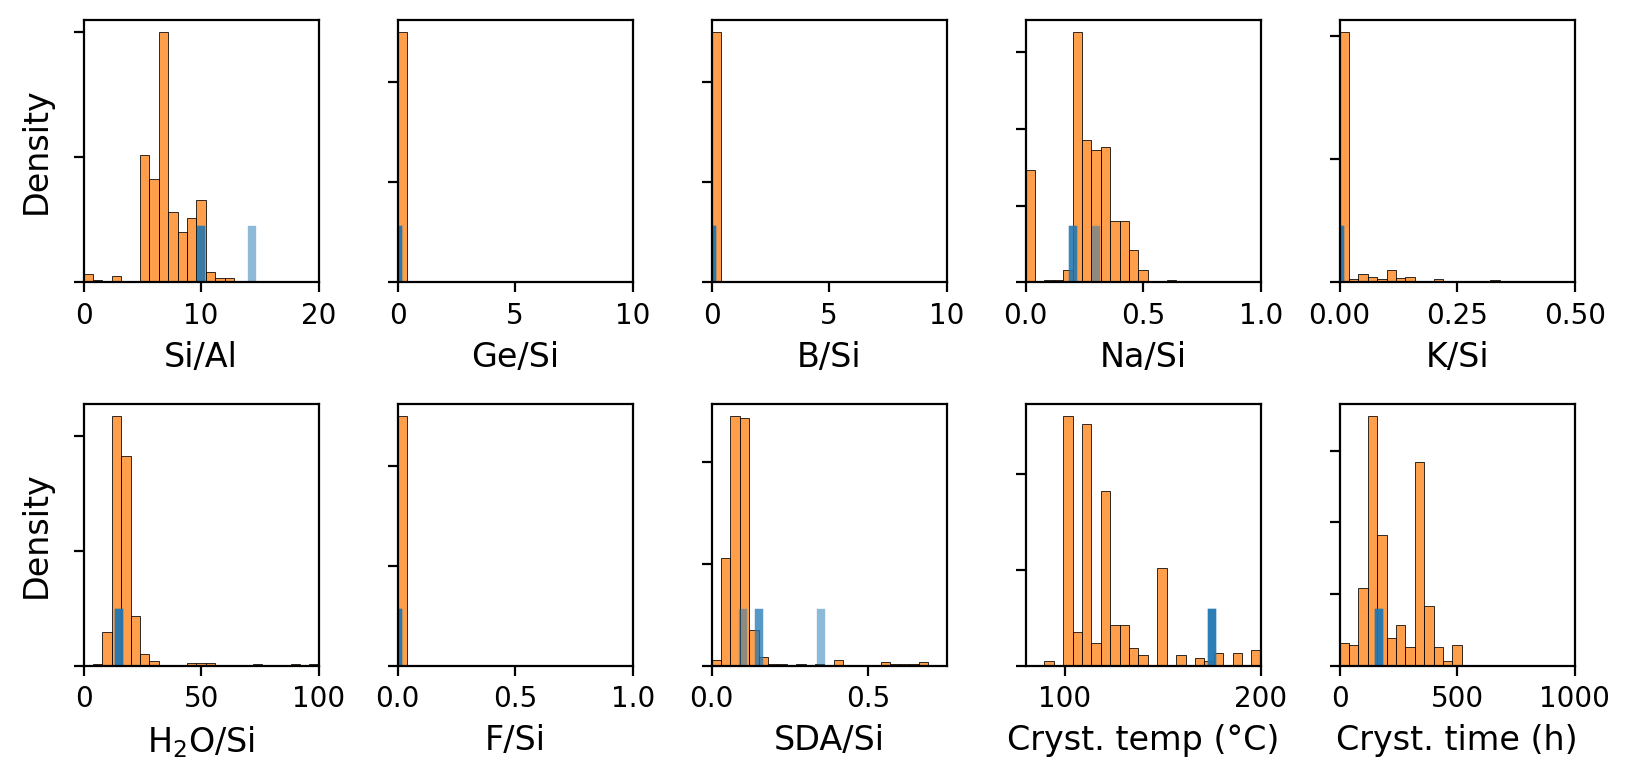

In [4]:
col2spec = {'Si/Al': {'xlim': (0, 20), 'name': 'Si/Al'},
            'Ge/Si': {'xlim': (0, 10), 'name': 'Ge/Si'},
            'B/Si': {'xlim': (0, 10), 'name': 'B/Si'},
            'Na/Si': {'xlim': (0, 1), 'name': 'Na/Si'},
            'K/Si': {'xlim': (0, 0.5),  'name': 'K/Si'},
            'H2O/Si': {'xlim': (0, 100), 'name': 'H$_2$O/Si'},
            'F/Si': {'xlim': (0, 1), 'name': 'F/Si'},
            'sda1/Si': {'xlim': (0, 0.75), 'name': 'SDA/Si'},
            'cryst_temp': {'xlim': (80, 200), 'name': 'Cryst. temp (°C)'},
            'cryst_time': {'xlim': (0, 1000), 'name': 'Cryst. time (h)'},
            }

fig = plt.figure(figsize=(8, 4), dpi=200)

for i, col in enumerate(col2spec.keys()):
    ax = fig.add_subplot(2, 5, i+1)
    plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
                 binrange=col2spec[col]['xlim'], bins=25,
                 stat='density',
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    ylim = plot.get_ylim()
    for v in true[col]:
        plt.plot([v, v], [0, 0.2 * ylim[-1]], color='tab:blue', linewidth=3, label='Experimental',
                 alpha=0.5
                 )
    plt.xlim(*col2spec[col]['xlim'])
    plt.xlabel(col2spec[col]['name'])
    if i % 5 != 0:
        plt.ylabel('')
    ax.set_yticklabels([])

plt.subplots_adjust(wspace=-2, hspace=None)
plt.tight_layout()
plt.show()

In [5]:
pred

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
2,5.000000,1.717997,99.0,250.0,0.400000,0.000000,0.000000,0.0,13.810024,0.058335,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,16.572029,16.572029,0.070002,0.070002
3,6.493506,1.717997,99.0,250.0,0.232078,0.000000,0.000000,0.0,14.705882,0.146234,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,16.970588,16.970588,0.168754,0.168754
7,6.915221,1.717997,99.0,250.0,0.237799,0.000000,0.152171,0.0,13.690950,0.062584,...,0.000000,0.000000,0.174176,0.174176,0.0,0.0,15.670778,15.670778,0.071634,0.071634
8,6.015513,1.717997,99.0,250.0,0.000000,0.380100,0.598626,0.0,18.838392,0.050000,...,0.443286,0.443286,0.698140,0.698140,0.0,0.0,21.970027,21.970027,0.058312,0.058312
10,6.493506,1.717997,99.0,250.0,0.333217,0.000000,0.238015,0.0,13.018894,0.064279,...,0.000000,0.000000,0.274670,0.274670,0.0,0.0,15.023804,15.023804,0.074178,0.074178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,6.600000,1.717997,99.0,250.0,0.321364,0.000000,0.232446,0.0,11.177830,0.082164,...,0.000000,0.000000,0.267666,0.267666,0.0,0.0,12.871441,12.871441,0.094613,0.094613
995,11.017051,1.717997,99.0,250.0,0.000000,0.276701,0.295514,0.0,15.350738,0.041667,...,0.301817,0.301817,0.322337,0.322337,0.0,0.0,16.744100,16.744100,0.045449,0.045449
996,8.000000,1.717997,99.0,250.0,0.195946,0.000903,0.174618,0.0,17.970549,0.112469,...,0.001016,0.001016,0.196445,0.196445,0.0,0.0,20.216868,20.216868,0.126528,0.126528
997,9.091000,1.717997,99.0,250.0,0.297851,0.000000,0.300000,0.0,14.066074,0.062675,...,0.000000,0.000000,0.333000,0.333000,0.0,0.0,15.613327,15.613327,0.069569,0.069569


In [6]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
lit = dataset.get_datapoints_by_index(dataset_idxs=range(len(dataset)), scaled=False, return_dataframe=True)[1]
lit = lit[lit['Si/Al'] > 0]

# Preprocess to unnormalized molar ratios
hets = ['Al', 'Ge', 'B']
thresholds = [0.00251, 0.099990, 0.004001]
for het, thres in zip(hets, thresholds):

    lit[f'{het}/Si'] = 1. / lit[f'Si/{het}']
    lit[f'{het}/Si'] = lit[f'{het}/Si'].map(lambda x: 0. if x <= thres else x)
    lit[f'{het}'] = lit[f'{het}/Si']
    lit['Si'] = [1.]*len(lit)

tot_hets = lit[['Si']+hets].sum(1) # sum of heteroatoms fractions

for c in ['Na', 'K', 'OH', 'F', 'H2O', 'sda1']:
    lit[f'{c}'] = lit[f'{c}/T'] * tot_hets
    lit[f'{c}/Si'] = lit[f'{c}'] / lit['Si']

In [7]:
lit

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,K,K/Si,OH,OH/Si,F,F/Si,H2O,H2O/Si,sda1,sda1/Si
0,400.0,0.000000,99.0,250.0,0.0,0.05,0.250000,0.0,31.000006,0.200000,...,0.05,0.05,0.250000,0.250000,0.0,0.0,31.000006,31.000006,0.20,0.20
1,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,7.500000,0.500000,...,0.00,0.00,0.000000,0.000000,0.5,0.5,7.500000,7.500000,0.50,0.50
2,400.0,0.000000,99.0,250.0,0.0,0.12,0.270000,0.0,44.000000,0.150000,...,0.12,0.12,0.270000,0.270000,0.0,0.0,44.000000,44.000000,0.15,0.15
3,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,20.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.5,0.5,20.000000,20.000000,0.00,0.00
4,2.5,1.717997,99.0,250.0,0.0,0.00,2.285717,0.0,28.571430,1.142857,...,0.00,0.00,3.200004,3.200004,0.0,0.0,40.000003,40.000003,1.60,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,30.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00
23957,40.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00
23958,70.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00
23959,100.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00,0.00


# Normal font size

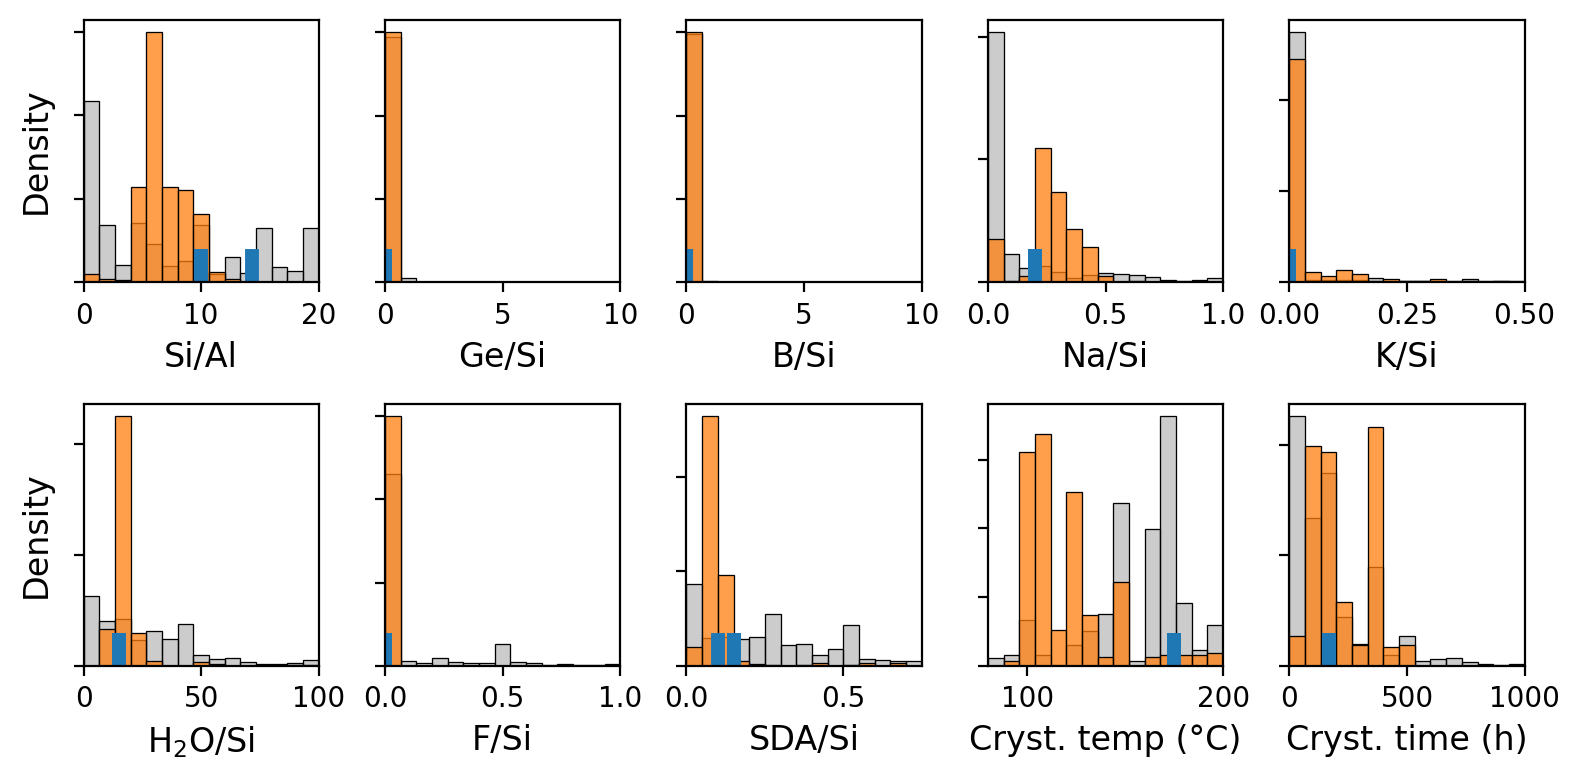

In [8]:
col2spec = {'Si/Al': {'xlim': (0, 20), 'name': 'Si/Al'},
            'Ge/Si': {'xlim': (0, 10), 'name': 'Ge/Si'},
            'B/Si': {'xlim': (0, 10), 'name': 'B/Si'},
            'Na/Si': {'xlim': (0, 1), 'name': 'Na/Si'},
            'K/Si': {'xlim': (0, 0.5),  'name': 'K/Si'},
            'H2O/Si': {'xlim': (0, 100), 'name': 'H$_2$O/Si'},
            'F/Si': {'xlim': (0, 1), 'name': 'F/Si'},
            'sda1/Si': {'xlim': (0, 0.75), 'name': 'SDA/Si'},
            'cryst_temp': {'xlim': (80, 200), 'name': 'Cryst. temp (°C)'},
            'cryst_time': {'xlim': (0, 1000), 'name': 'Cryst. time (h)'},
            }

fig = plt.figure(figsize=(8, 4), dpi=200)

for i, col in enumerate(col2spec.keys()):
    ax = fig.add_subplot(2, 5, i+1)
    sns.histplot(lit[col], color='grey', label='Literature', 
                 binrange=col2spec[col]['xlim'], bins=15,
                 stat='density',
                 alpha=0.4
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
                 binrange=col2spec[col]['xlim'], bins=15,
                 stat='density',
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    ylim = plot.get_ylim()
    for v in true[col].iloc[[0,1,3]]:
        plt.plot([v, v], [0, 0.1 * ylim[-1]], color='tab:blue', linewidth=5, label='Experimental',
                 alpha=1.
                 )
    plt.xlim(*col2spec[col]['xlim'])
    plt.xlabel(col2spec[col]['name'])
    if i % 5 != 0:
        plt.ylabel('')
    ax.set_yticklabels([])

plt.subplots_adjust(wspace=3, hspace=None)
plt.tight_layout()
# plt.savefig(f'figs/EXP-CS1/aggregated.pdf', dpi=200, bbox_inches='tight')
plt.show()

# Larger font size

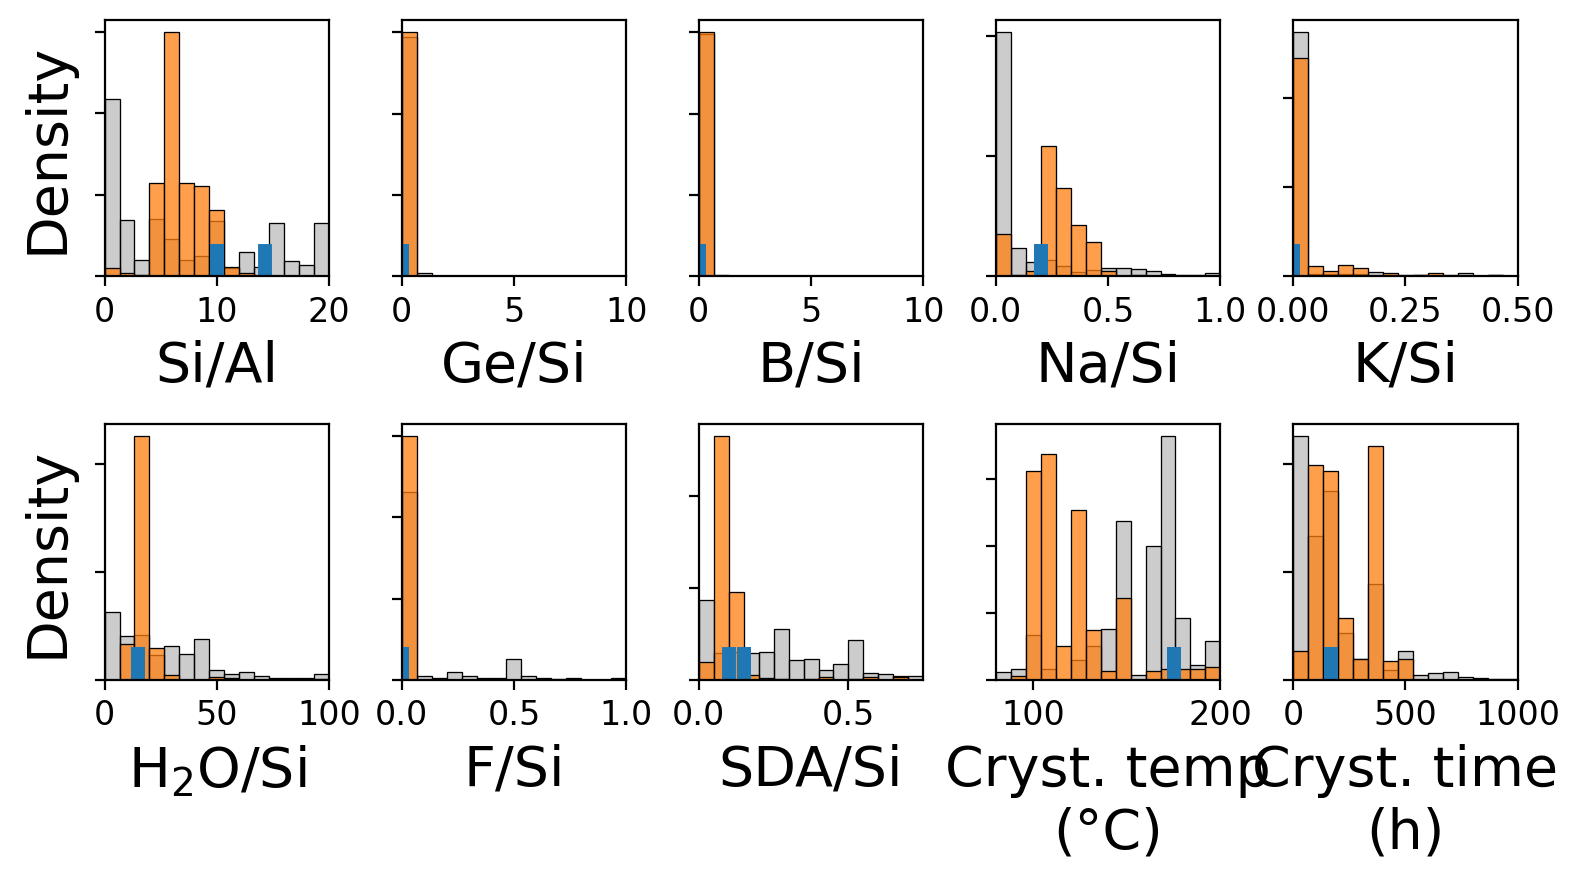

In [9]:
col2spec = {'Si/Al': {'xlim': (0, 20), 'name': 'Si/Al'},
            'Ge/Si': {'xlim': (0, 10), 'name': 'Ge/Si'},
            'B/Si': {'xlim': (0, 10), 'name': 'B/Si'},
            'Na/Si': {'xlim': (0, 1), 'name': 'Na/Si'},
            'K/Si': {'xlim': (0, 0.5),  'name': 'K/Si'},
            'H2O/Si': {'xlim': (0, 100), 'name': 'H$_2$O/Si'},
            'F/Si': {'xlim': (0, 1), 'name': 'F/Si'},
            'sda1/Si': {'xlim': (0, 0.75), 'name': 'SDA/Si'},
            'cryst_temp': {'xlim': (80, 200), 'name': 'Cryst. temp\n(°C)'},
            'cryst_time': {'xlim': (0, 1000), 'name': 'Cryst. time\n(h)'},
            }

fig = plt.figure(figsize=(8, 4.5), dpi=200)

for i, col in enumerate(col2spec.keys()):
    ax = fig.add_subplot(2, 5, i+1)
    sns.histplot(lit[col], color='grey', label='Literature', 
                 binrange=col2spec[col]['xlim'], bins=15,
                 stat='density',
                 alpha=0.4
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
                 binrange=col2spec[col]['xlim'], bins=15,
                 stat='density',
                #  kde=True, kde_kws={'bw_adjust': 0.5}
                 )
    ylim = plot.get_ylim()
    for v in true[col].iloc[[0,1,3]]:
        plt.plot([v, v], [0, 0.1 * ylim[-1]], color='tab:blue', linewidth=5, label='Experimental',
                 alpha=1.
                 )
    plt.xlim(*col2spec[col]['xlim'])
    plt.xlabel(col2spec[col]['name'], fontsize=20)
    plt.xticks(fontsize=12)
    if i % 5 != 0:
        plt.ylabel('')
    else:
        plt.ylabel('Density', fontsize=20)
    ax.set_yticklabels([])

plt.subplots_adjust(wspace=3, hspace=None)
plt.tight_layout()
# plt.savefig(f'figs/EXP-CS1/aggregated.pdf', dpi=200, bbox_inches='tight')
plt.show()

# PCA

In [10]:
true

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time
0,10.0,0.0,0.0,0.2,0.0,15.0,0.0,0.15,175.0,168.0
1,14.3,0.0,0.0,0.2,0.0,15.0,0.0,0.15,175.0,168.0
2,10.0,0.0,0.0,0.3,0.0,15.0,0.0,0.35,175.0,168.0
3,10.0,0.0,0.0,0.2,0.0,15.0,0.0,0.10,175.0,168.0


In [11]:
pred[col2spec.keys()]

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time
2,5.000000,0.0,0.0,0.480000,0.000000,16.572029,0.0,0.070002,90.0,168.00000
3,6.493506,0.0,0.0,0.267818,0.000000,16.970588,0.0,0.168754,200.0,120.00000
7,6.915221,0.0,0.0,0.272187,0.000000,15.670778,0.0,0.071634,110.0,413.26398
8,6.015513,0.0,0.0,0.000000,0.443286,21.970027,0.0,0.058312,150.0,96.00000
10,6.493506,0.0,0.0,0.384532,0.000000,15.023804,0.0,0.074178,120.0,144.00000
...,...,...,...,...,...,...,...,...,...,...
994,6.600000,0.0,0.0,0.370056,0.000000,12.871441,0.0,0.094613,120.0,120.00000
995,11.017051,0.0,0.0,0.000000,0.301817,16.744100,0.0,0.045449,120.0,240.00000
996,8.000000,0.0,0.0,0.220439,0.001016,20.216868,0.0,0.126528,110.0,336.00000
997,9.091000,0.0,0.0,0.330614,0.000000,15.613327,0.0,0.069569,100.0,120.00000


In [12]:
lit[col2spec.keys()]

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time
0,400.0,0.0,0.0,0.0,0.05,31.000006,0.0,0.20,150.000000,504.000000
1,400.0,0.0,0.0,0.0,0.00,7.500000,0.5,0.50,175.000000,168.000000
2,400.0,0.0,0.0,0.0,0.12,44.000000,0.0,0.15,150.000000,144.000000
3,400.0,0.0,0.0,0.0,0.00,20.000000,0.5,0.00,115.720856,660.165100
4,2.5,0.0,0.0,0.0,0.00,40.000003,0.0,1.60,125.000000,72.000000
...,...,...,...,...,...,...,...,...,...,...
23956,30.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,135.000000,558.916321
23957,40.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,160.000000,240.032150
23958,70.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,170.000000,53.891212
23959,100.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,170.000000,193.911392


In [13]:
combined = pd.concat([true, pred[col2spec.keys()], lit[col2spec.keys()]], axis=0).reset_index(drop=True)
true_idx = np.arange(0, len(true))
pred_idx = np.arange(len(true), len(true)+len(pred))
lit_idx = np.arange(len(true)+len(pred), len(true)+len(pred)+len(lit))
combined

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time
0,10.0,0.0,0.0,0.20,0.0,15.000000,0.0,0.150000,175.0,168.000000
1,14.3,0.0,0.0,0.20,0.0,15.000000,0.0,0.150000,175.0,168.000000
2,10.0,0.0,0.0,0.30,0.0,15.000000,0.0,0.350000,175.0,168.000000
3,10.0,0.0,0.0,0.20,0.0,15.000000,0.0,0.100000,175.0,168.000000
4,5.0,0.0,0.0,0.48,0.0,16.572029,0.0,0.070002,90.0,168.000000
...,...,...,...,...,...,...,...,...,...,...
20566,30.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,135.0,558.916321
20567,40.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,160.0,240.032150
20568,70.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,170.0,53.891212
20569,100.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,170.0,193.911392


In [14]:
combined

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time
0,10.0,0.0,0.0,0.20,0.0,15.000000,0.0,0.150000,175.0,168.000000
1,14.3,0.0,0.0,0.20,0.0,15.000000,0.0,0.150000,175.0,168.000000
2,10.0,0.0,0.0,0.30,0.0,15.000000,0.0,0.350000,175.0,168.000000
3,10.0,0.0,0.0,0.20,0.0,15.000000,0.0,0.100000,175.0,168.000000
4,5.0,0.0,0.0,0.48,0.0,16.572029,0.0,0.070002,90.0,168.000000
...,...,...,...,...,...,...,...,...,...,...
20566,30.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,135.0,558.916321
20567,40.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,160.0,240.032150
20568,70.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,170.0,53.891212
20569,100.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,170.0,193.911392


In [15]:
X = combined

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)
combined['PCA 1'] = X_pca[:, 0]
combined['PCA 2'] = X_pca[:, 1]
combined

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time,PCA 1,PCA 2
0,10.0,0.0,0.0,0.20,0.0,15.000000,0.0,0.150000,175.0,168.000000,-0.290052,0.167645
1,14.3,0.0,0.0,0.20,0.0,15.000000,0.0,0.150000,175.0,168.000000,-0.289906,0.162831
2,10.0,0.0,0.0,0.30,0.0,15.000000,0.0,0.350000,175.0,168.000000,-0.219633,0.212194
3,10.0,0.0,0.0,0.20,0.0,15.000000,0.0,0.100000,175.0,168.000000,-0.298336,0.168661
4,5.0,0.0,0.0,0.48,0.0,16.572029,0.0,0.070002,90.0,168.000000,-0.198307,0.788088
...,...,...,...,...,...,...,...,...,...,...,...,...
20566,30.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,135.0,558.916321,-0.450265,0.232440
20567,40.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,160.0,240.032150,-0.417315,0.113087
20568,70.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,170.0,53.891212,-0.397344,0.042132
20569,100.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,170.0,193.911392,-0.410464,-0.005523


In [16]:
combined.iloc[pred_idx]

,Si/Al,Ge/Si,B/Si,Na/Si,K/Si,H2O/Si,F/Si,sda1/Si,cryst_temp,cryst_time,PCA 1,PCA 2
4,5.000000,0.0,0.0,0.480000,0.000000,16.572029,0.0,0.070002,90.0,168.00000,-0.198307,0.788088
5,6.493506,0.0,0.0,0.267818,0.000000,16.970588,0.0,0.168754,200.0,120.00000,-0.253704,0.069255
6,6.915221,0.0,0.0,0.272187,0.000000,15.670778,0.0,0.071634,110.0,413.26398,-0.301141,0.547843
7,6.015513,0.0,0.0,0.000000,0.443286,21.970027,0.0,0.058312,150.0,96.00000,-0.369539,0.258460
8,6.493506,0.0,0.0,0.384532,0.000000,15.023804,0.0,0.074178,120.0,144.00000,-0.232422,0.573700
...,...,...,...,...,...,...,...,...,...,...,...,...
390,6.600000,0.0,0.0,0.370056,0.000000,12.871441,0.0,0.094613,120.0,120.00000,-0.235068,0.568012
391,11.017051,0.0,0.0,0.000000,0.301817,16.744100,0.0,0.045449,120.0,240.00000,-0.391954,0.395227
392,8.000000,0.0,0.0,0.220439,0.001016,20.216868,0.0,0.126528,110.0,336.00000,-0.297052,0.529314
393,9.091000,0.0,0.0,0.330614,0.000000,15.613327,0.0,0.069569,100.0,120.00000,-0.250281,0.659401


In [17]:
# Get likelihood of generated samples
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(combined.iloc[pred_idx])
likelihood = kde.score_samples(combined.iloc[pred_idx])
_pred = combined.iloc[pred_idx].copy()
_pred['likelihood'] = likelihood

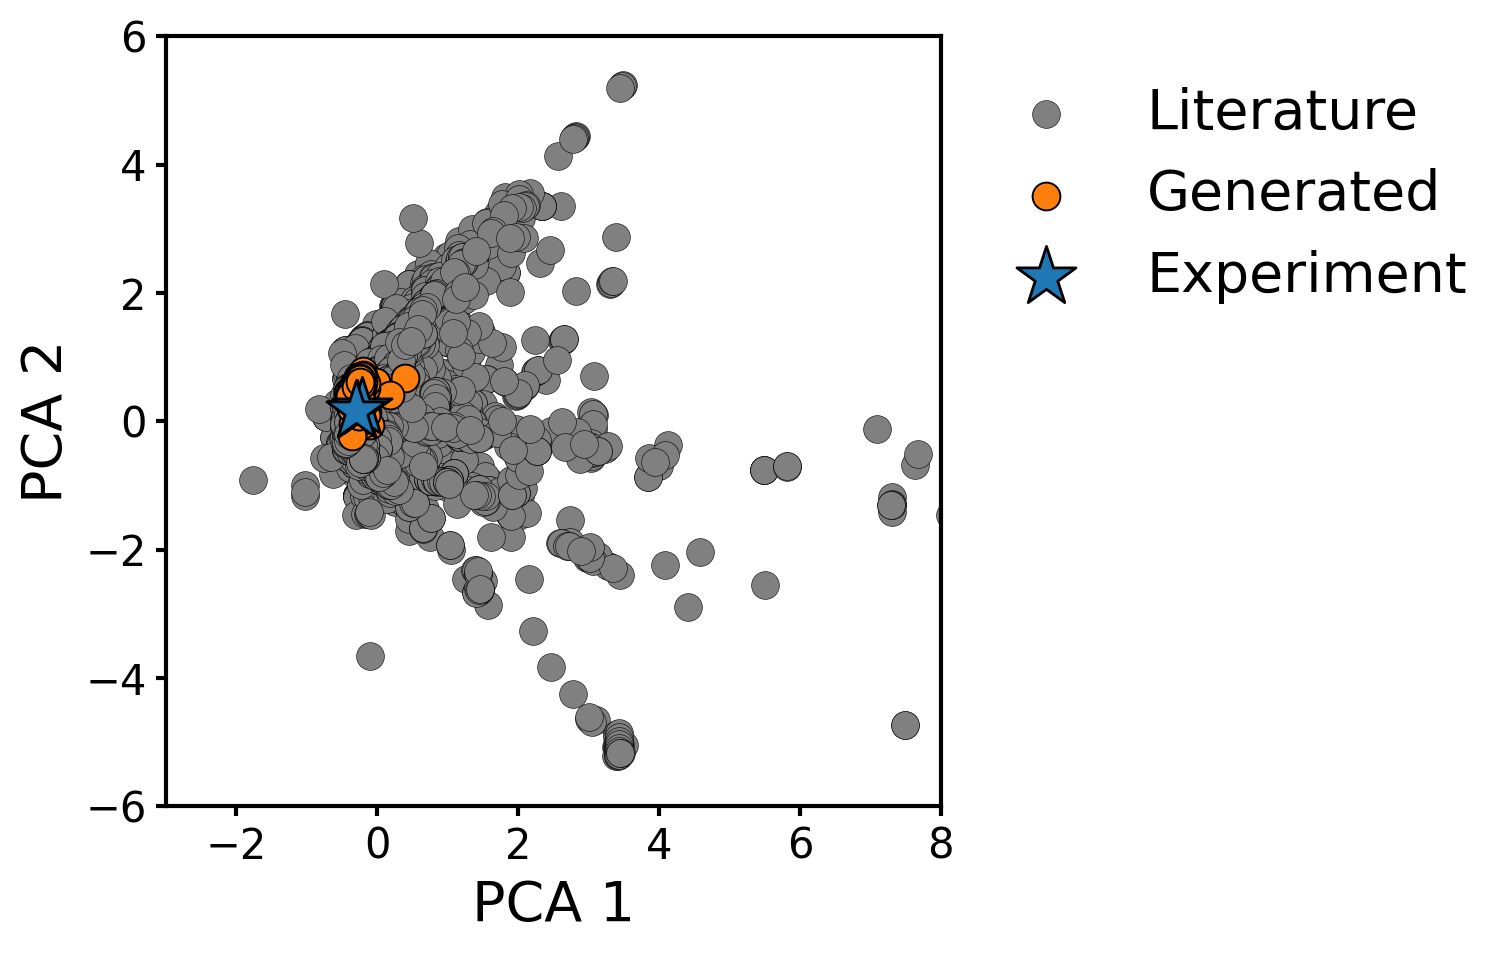

In [18]:
metric = 'PCA'

thres = -np.inf

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(combined.iloc[lit_idx][f'{metric} 1'], combined.iloc[lit_idx][f'{metric} 2'], c='grey', label='Literature', marker='o', s=100, linewidth=0.2,  edgecolor='black', alpha=1.,
            )
plt.scatter(_pred[_pred['likelihood'] > thres][f'{metric} 1'], _pred[_pred['likelihood'] > thres][f'{metric} 2'], c='tab:orange', label='Generated', marker='o', s=100, linewidth=0.7,  edgecolor='black', alpha=1.,
            )
plt.scatter(combined.iloc[true_idx][f'{metric} 1'], combined.iloc[true_idx][f'{metric} 2'], c='tab:blue', label='Experiment', marker='*', s=500, linewidth=1.,  edgecolor='black', alpha=1.,
            )
plt.xlabel(f'{metric} 1', fontsize=20)
plt.ylabel(f'{metric} 2', fontsize=20)
plt.xlim(-3, 8)
plt.ylim(-6, 6)
ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.tick_params(width=1.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig(f'figs/EXP-CS1/pca.pdf', dpi=200, bbox_inches='tight')
plt.show()

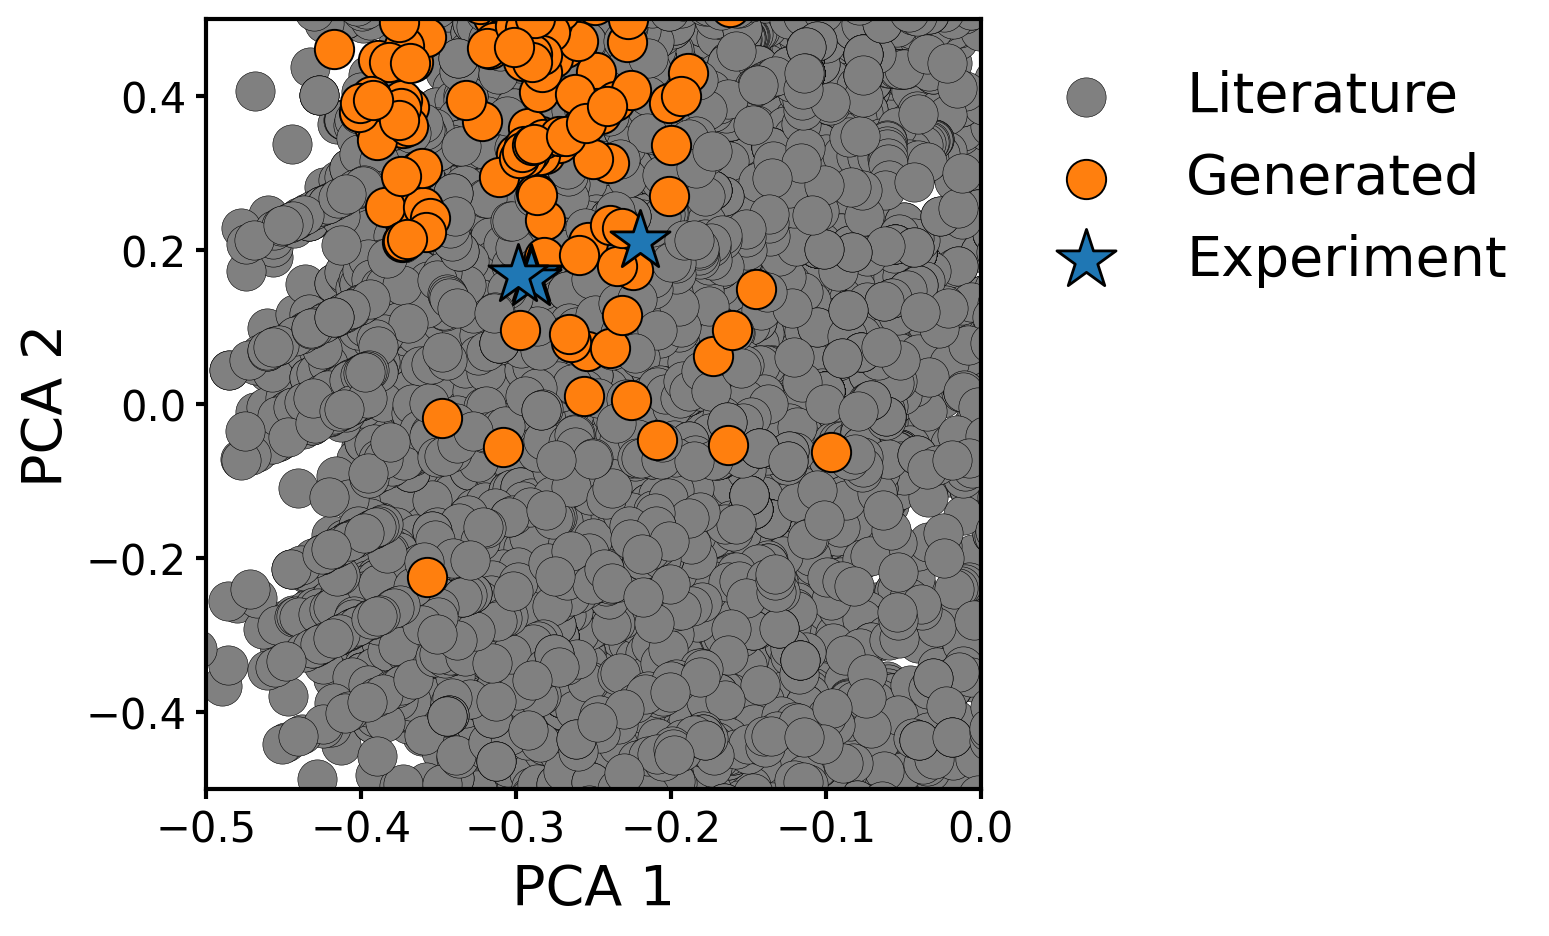

In [19]:
metric = 'PCA'
# metric = 't-SNE'

thres = -np.inf

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(combined.iloc[lit_idx][f'{metric} 1'], combined.iloc[lit_idx][f'{metric} 2'], c='grey', label='Literature', marker='o', s=200, linewidth=0.2,  edgecolor='black', alpha=1.,
            )
plt.scatter(_pred[_pred['likelihood'] > thres][f'{metric} 1'], _pred[_pred['likelihood'] > thres][f'{metric} 2'], c='tab:orange', label='Generated', marker='o', s=200, linewidth=0.7,  edgecolor='black', alpha=1.,
            )
plt.scatter(combined.iloc[true_idx][f'{metric} 1'], combined.iloc[true_idx][f'{metric} 2'], c='tab:blue', label='Experiment', marker='*', s=500, linewidth=1.,  edgecolor='black', alpha=1.,
            )
plt.xlabel(f'{metric} 1', fontsize=20)
plt.ylabel(f'{metric} 2', fontsize=20)
plt.xlim(-0.5, 0.0)
plt.ylim(-0.5, 0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.tick_params(width=1.5)
plt.show()